In [161]:
import pandas as pd
import geopandas as gpd
import math
from shapely.geometry import Polygon, MultiPolygon
from numpy import arange
from matplotlib import pyplot as plt, ticker

In [5]:
fortaleza = gpd.read_file('Dados/Densidade_Populacional_por_Bairros.zip')

In [6]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [7]:
def criar_celula(lat, lng, passo):
    return Polygon([(lat, lng), (lat + passo, lng), (lat + passo, lng + passo), (lat, lng + passo)])

In [8]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 2) for b in fortaleza.geometry.unary_union.bounds)

In [9]:
p = 0.01

In [11]:
grade_completa = MultiPolygon((criar_celula(x, y, p) for x in arange(x_min - p, x_max + p, p) for y in arange(y_min - p, y_max + p, p)))   

In [12]:
grade_fortaleza = MultiPolygon([c for c in grade_completa.geoms if c.intersects(fortaleza.unary_union)])

<AxesSubplot:>

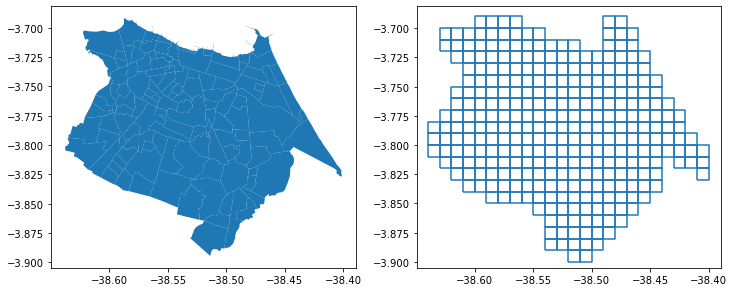

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fortaleza.plot(ax=ax1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
gpd.GeoSeries(grade_fortaleza).boundary.plot(ax=ax2)

In [31]:
pedidos_fortaleza = pd.read_csv('Dados/New_query_2023_07_11.csv')

In [119]:
pedidos_por_rest = pedidos_fortaleza['frn_id'].value_counts().reset_index().rename(columns={"index": 'frn_id', "frn_id": 'pedidos'})

In [120]:
tamanho_amostra = 5

In [134]:
rests_amostra = pedidos_por_rest[pedidos_por_rest.pedidos > 3000][['frn_id']].drop_duplicates().sample(n=tamanho_amostra, random_state=123)

In [135]:
pedidos_amostra = pedidos_fortaleza.merge(rests_amostra, on='frn_id')

In [136]:
pedidos_amostra['hr_pedido'] = pd.to_datetime(pedidos_amostra['ini_pedido']).dt.hour

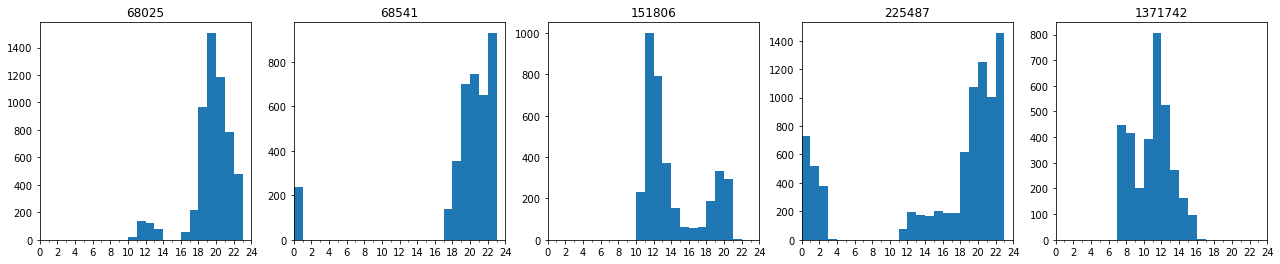

In [166]:
fig, axs = plt.subplots(nrows=math.floor(tamanho_amostra / 5), ncols=5, figsize=(22, 4))
grupos_rests = pedidos_amostra.groupby('frn_id')

for (grp, df), ax in zip(grupos_rests, axs.ravel()):
    df['hr_pedido'].plot(kind='hist', bins=range(24), ax=ax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim((0, 24))
    ax.set_ylabel('')
    ax.set_title(grp)

In [133]:
pedidos_amostra

,order_id,last_status,ini_pedido,delivery_by,fim_pedido,cli_lat,cli_lng,frn_id,trading_name,dish_type,rst_lat,rst_lng,hr_pedido
0,a0d8e812-d336-4603-a034-db2c858c7c6f,CONCLUDED,2022-12-30 11:16:30.049577,MERCHANT,2022-12-30 11:56:41.019769,-3.775,-38.552,179797,Nippon Culinaria Japonesa Sushi & Temaki,Comida Japonesa,-3.748496,-38.528052,11
1,b8c1eb0f-a7a3-43fa-aea2-fb2393d888f7,CONCLUDED,2022-12-30 19:52:10.725118,IFOOD,2022-12-30 20:31:19.278536,-3.780,-38.548,179797,Nippon Culinaria Japonesa Sushi & Temaki,Comida Japonesa,-3.748496,-38.528052,19
2,3090f5b8-973f-4883-b671-0bd3e6579d44,CONCLUDED,2022-12-30 17:54:18.590247,MERCHANT,2022-12-30 18:25:53.395256,-3.754,-38.526,179797,Nippon Culinaria Japonesa Sushi & Temaki,Comida Japonesa,-3.748496,-38.528052,17
3,d6d2128c-f6e8-403e-8ddf-b376dc7b6132,CONCLUDED,2022-12-30 19:58:57.435060,IFOOD,2022-12-30 20:45:59.959648,-3.767,-38.495,179797,Nippon Culinaria Japonesa Sushi & Temaki,Comida Japonesa,-3.748496,-38.528052,19
4,395f4f6f-e865-4745-a0e9-99561817ebed,CONCLUDED,2022-12-30 12:48:40.560651,MERCHANT,2022-12-30 13:14:39.264764,-3.734,-38.517,179797,Nippon Culinaria Japonesa Sushi & Temaki,Comida Japonesa,-3.748496,-38.528052,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14028,fdf03fcc-607d-4f00-aee4-cbe07b66f378,CONCLUDED,2023-01-11 21:53:44.259578,IFOOD,2023-01-11 22:12:46.835082,-3.801,-38.561,1057605,San Paolo Gelato - Parangaba,Sorvetes,-3.779043,-38.559444,21
14029,b58b309d-e62f-463b-b216-f1d9999ebc8c,CONCLUDED,2023-02-02 21:55:55.873036,IFOOD,2023-02-02 22:22:42.852405,-3.768,-38.576,1057605,San Paolo Gelato - Parangaba,Sorvetes,-3.779043,-38.559444,21
14030,b941d8e7-6eca-4cf9-adf2-af166ffc90ec,CONCLUDED,2023-01-28 20:47:45.372356,IFOOD,2023-01-28 21:18:36.745379,-3.796,-38.561,1057605,San Paolo Gelato - Parangaba,Sorvetes,-3.779043,-38.559444,20
14031,a70c0c6c-783c-4c5a-96f5-83d780440bb5,CONCLUDED,2023-01-27 21:57:31.429674,IFOOD,2023-01-27 22:24:09.039502,-3.775,-38.552,1057605,San Paolo Gelato - Parangaba,Sorvetes,-3.779043,-38.559444,21
